In [34]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import collections
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from experiment_220322_resnet_model import CnnboardResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
online_network = CnnboardResNet().to(device)
online_network.load_state_dict(torch.load("out-220322-train2/model15.pth"))

target_network = CnnboardResNet().to(device)
target_network.load_state_dict(torch.load("out-220322-train2/model15.pth"))

<All keys matched successfully>

In [21]:
from bombergym.scenarios import classic, classic_with_opponents
from bombergym.environments import register

register()
settings, agents = classic_with_opponents()

env = gym.make('BomberGym-v4', args=settings, agents=agents)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.0025)

In [26]:
def get_action(online_net, observation, transposer, epsilon=.05):
    if random.random() < .05:
        # Exploration: Choose random action
        return random.randrange(6)
    else:
        # Exploitation: Choose online network observationt action
        return transposer(online_net, observation.astype(np.float32))

In [164]:
def process_batch(online_net, target_net, buffer, batch_size=128, gamma=.99):
    if len(buffer) < batch_size: 
        return
    # Uniform sample from experience replay buffer - Lin, 1992
    sample = np.array(random.sample(experience_replay_buffer, 128), dtype=object)
    states = sample[:, 0]

    criterion = torch.nn.HuberLoss()

    state_batch = torch.from_numpy(np.concatenate(states)[np.newaxis, :].reshape(128, 5, 17, 17)).to(device, torch.float32)
    next_state_batch = torch.from_numpy(np.concatenate(sample[:, 2])[np.newaxis, :].reshape(128, 5, 17, 17)).to(device, torch.float32)
    actions = torch.from_numpy(sample[:, 1].astype(np.int64)).to(device)
    rewards = torch.from_numpy(sample[:, 3].astype(np.int32)).to(device)

    # Corresponding Q-values according to online network
    online_q_values = online_network(state_batch).gather(1, actions.unsqueeze(1)).squeeze()

    # Q-values of next observation according to target network (older)
    next_q_values = target_network(next_state_batch).max(dim=1).values

    # Bellmann Eqn., => Q-values we should have got according to actual rewards
    expected_q_values = target_q_values * gamma + rewards

    loss = criterion(online_q_values, expected_q_values)
    
    # Regular torch optimization routine - with gradient clipping
    optimizer.zero_grad()
    loss.backward()
    # Clamp Gradient: Recommended in "Human level control"
    # Nature Paper.
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

In [168]:
experience_replay_buffer = collections.deque(maxlen=1000)
batch_size=128

# Double DQN Paper: "For the tuned version of Double DQN, we increased the num-
# ber of frames between each two copies of the target network
# from 10,000 to 30,000, to reduce overestimations further"
episode_update_interval = 30000 // batch_size

for episode in range(10):
    obs = env.reset()
    initial_config = detect_initial_configuration(obs)
    transposer = get_transposer(initial_config)
    while True:
        action = get_action(online_network, obs, transposer)
        next_obs, reward, done, other = env.step(action)
        if not done:
            experience_replay_buffer.append((obs, action, next_obs, reward))
        obs = next_obs
        loss = optimize_model(online_network, target_network, experience_replay_buffer, batch_size=batch_size)
        if done:
            break

    if episode % episode_update_interval == 0:
        print("Updating target network")
        target_network.load_state_dict(online_network.state_dict())

Updating target network


In [7]:
def detect_initial_configuration(obs):
    agent_frame = obs[4, :, :]
    x, y = (agent_frame == 1).nonzero()
    x, y = x[0], y[0]
    config = None
    if x < 7 and y > 7:
        config = 'bottom-left'
    if x > 7 and y < 7:
        config = 'top-right'
    if x < 7 and y < 7:
        config = 'top-left'
    if x > 7 and y > 7:
        config = 'bottom-right'
    return config

def get_transposer(config):
    if config == 'top-left':
        return lambda model, input: model(torch.from_numpy(input).unsqueeze(0).to(device)).argmax().item()
    elif config == 'top-right':
        return transposer_lr
    elif config == 'bottom-left':
        return transposer_td
    else:
        return transposer_lrtd

def transposer_lr(model, inp):
    input_aug = inp[:, ::-1, :].copy()
    action = model(torch.from_numpy(input_aug).unsqueeze(0).to(device)).argmax().item()
    new_action_lr = None
    if action == 1: # Right
        new_action_lr = 3 # Left
    elif action == 3: # Left
        new_action_lr = 1 # Right
    else:
        new_action_lr = action
    return new_action_lr

def transposer_td(model, inp):
    input_aug = inp[:, :, ::-1].copy()
    action = model(torch.from_numpy(input_aug).unsqueeze(0).to(device)).argmax().item()
    new_action_ud = None
    if action == 0: # Up
        new_action_ud = 2 # down
    elif action == 2: # Down
        new_action_ud = 0 # Up
    else:
        new_action_ud = action
    return new_action_ud

def transposer_lrtd(model, inp):
    input_aug = inp[:, ::-1, ::-1].copy()
    action = model(torch.from_numpy(input_aug).unsqueeze(0).to(device)).argmax().item()
    new_action_udlr = None
    if action == 0: # Up
        new_action_udlr = 2 # down
    elif action == 2: # Down
        new_action_udlr = 0 # Up
    elif action == 1: # Right
        new_action_udlr = 3 # Left
    elif action == 3: # Left
        new_action_udlr = 1 # Right
    else:
        new_action_udlr = action
    return new_action_udlr

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.08
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = resnet18(
    norm_layer=lambda channels: torch.nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-5, affine=True),
    num_classes=6
).to(device)
policy_net.load_state_dict(torch.load("assets/experiment_220316_resnet18_moreepochs.pth", map_location=device))
policy_net.train()

target_net = resnet18(
    norm_layer=lambda channels: torch.nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-5, affine=True),
    num_classes=6
).to(device)
target_net.load_state_dict(torch.load("assets/experiment_220316_resnet18_moreepochs.pth", map_location=device))
target_net.train()

#optimizer = optim.RMSprop(policy_net.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.0025)

memory = ReplayMemory(10000)


steps_done = 0

def select_action(state, transposer):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return torch.tensor([[transposer(policy_net, state)]])
            #return policy_net(state.to(device)).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

Training loop
^^^^^^^^^^^^^

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch.to(device)).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states.to(device)).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    import pdb;pdb.set_trace()

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.detach().cpu().numpy()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.




In [8]:
def did_i_die(obs):
    return len((obs[4, :, :] == 1).nonzero()) == 0 or len((obs[0, :, :] == 1).nonzero()) == 0

In [20]:
num_episodes = 20000
episode_lengths = []
losses = []
episode_rewards = []
episode_mean_rewards = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    obs = env.reset()
    obs_torch = torch.from_numpy(obs).to(device, dtype=torch.float32).unsqueeze(0)
    initial_config = detect_initial_configuration(obs)
    transposer = get_transposer(initial_config)
    print(f'Config: {initial_config}')
    episode_length = 0
    episode_reward = 0
    episode_mean_reward = 0
    while True:
        # Select and perform an action
        
        action = select_action(obs.astype(np.float32), transposer)
        next_obs, reward, done, other = env.step(action.item())
        #print(other["events"], reward)
        episode_reward += reward
        #print(reward, other["events"])
        if done or did_i_die(next_obs):
            break
        next_obs_torch = torch.from_numpy(next_obs).to(device, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor([reward], device=device)
        
        # Store the transition in memory
        memory.push(obs_torch, action.to(device), next_obs_torch, reward)
        obs = next_obs

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model()
        if loss is not None:
            losses.append(loss)
        episode_length += 1

    episode_lengths.append(episode_length)
    episode_rewards.append(episode_reward)
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        print("Updating target net")
        target_net.load_state_dict(policy_net.state_dict())

Config: bottom-left
Updating target net
Config: top-left
Config: bottom-left
Config: top-left
Config: top-right
Config: bottom-left
Config: top-right
Config: top-right
Config: top-left
Config: top-right
Config: bottom-right
Updating target net
Config: top-left
Config: bottom-right
Config: top-right
Config: bottom-left
Config: top-left
Config: bottom-right
Config: bottom-right
Config: bottom-right
Config: top-right
Config: top-left
Updating target net
Config: bottom-left
Config: top-left
Config: bottom-left
Config: top-right
Config: top-left
Config: bottom-left
Config: bottom-left
Config: bottom-left
Config: top-right
Config: top-right
Updating target net
Config: bottom-right
Config: bottom-right
Config: top-left
Config: top-right
Config: top-left
Config: top-left
Config: bottom-right
Config: top-left
Config: bottom-left
Config: top-right
Updating target net
Config: bottom-left
Config: bottom-right
Config: top-right
Config: bottom-right
Config: bottom-right
Config: top-right
Config: top

KeyboardInterrupt: 

Here is the diagram that illustrates the overall resulting data flow.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. "Older" target_net is also used in optimization to compute the
expected Q values; it is updated occasionally to keep it current.




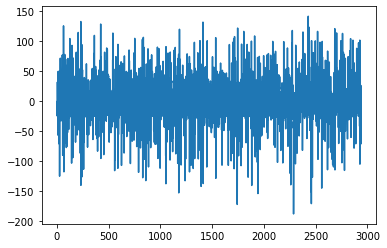

In [21]:
plt.plot(episode_rewards)

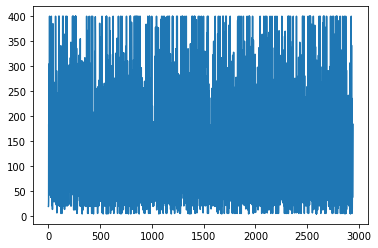

In [23]:
plt.plot(episode_lengths)

In [22]:
torch.save(policy_net.state_dict(),"dqn_test2.pth")

In [ ]:
num_episodes = 10000
episode_lengths = []
losses = []
episode_rewards = []
episode_mean_rewards = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    obs = env.reset()
    obs_torch = torch.from_numpy(obs).to(device, dtype=torch.float32).unsqueeze(0)
    initial_config = detect_initial_configuration(obs)
    transposer = get_transposer(initial_config)
    print(f'Config: {initial_config}')
    episode_length = 0
    episode_reward = 0
    episode_mean_reward = 0
    while True:
        # Select and perform an action
        
        action = select_action(obs.astype(np.float32), transposer)
        next_obs, reward, done, other = env.step(action.item())
        #print(other["events"], reward)
        episode_reward += reward
        #print(reward, other["events"])
        if done or did_i_die(next_obs):
            break
        next_obs_torch = torch.from_numpy(next_obs).to(device, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor([reward], device=device)
        
        # Store the transition in memory
        memory.push(obs_torch, action.to(device), next_obs_torch, reward)
        obs = next_obs

        # Perform one step of the optimization (on the policy network)
        #loss = optimize_model()
        #if loss is not None:
        #    losses.append(loss)
        episode_length += 1

    episode_lengths.append(episode_length)
    episode_rewards.append(episode_reward)
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        print("Updating target net")
        target_net.load_state_dict(policy_net.state_dict())